# Bagging and boosting KNN and stacking — assignment DA-AG-0010

---

## Question 1: Fundamental idea behind ensembles; bagging vs boosting

**Answer:**

Ensemble techniques combine multiple models to reduce variance and bias, improving robustness and generalization compared to a single learner. The core idea is that diverse models “vote” or average predictions, canceling individual errors and boosting overall performance.

- **Bagging (Bootstrap Aggregating):**  
  **Goal:** Reduce variance.  
  **Approach:** Train many models in parallel on different bootstrap samples (with replacement) of the training set; aggregate by averaging (regression) or majority vote (classification). Models are independent, and no emphasis is placed on “hard” samples.  
  **Outcome:** Stabilizes high-variance learners (e.g., decision trees), improves accuracy, and lowers overfitting by decorrelating models.

- **Boosting:**  
  **Goal:** Reduce bias (and variance) by focusing on difficult cases.  
  **Approach:** Train models sequentially; each learner tries to correct the mistakes of the previous one by reweighting samples or fitting residuals. Later models focus more on misclassified points.  
  **Outcome:** Builds a strong learner from weak learners; powerful but more sensitive to noise and requires careful regularization.

---

## Question 2: Random Forest vs single decision tree overfitting; key hyperparameters

**Answer:**

Random Forest reduces overfitting by combining many decorrelated decision trees and averaging their predictions. Two randomness sources drive decorrelation: bootstrap sampling of data for each tree, and random subspace selection of features at each split. Averaging lowers variance while preserving predictive signal.

- **Key hyperparameter — n_estimators:**  
  **Role:** Number of trees. More trees reduce variance and stabilize predictions; too few may underfit, while too many mainly increase compute time but rarely harm performance due to averaging.

- **Key hyperparameter — max_features:**  
  **Role:** Number of features considered per split. Smaller values increase tree diversity (lower correlation), improving generalization; larger values can make trees more similar and increase variance.

Additional helpful hyperparameters include **max_depth** (limits tree complexity) and **min_samples_leaf** (prevents overly specific splits), which further curb overfitting.

---

## Question 3: Stacking; differences vs bagging/boosting; example

**Answer:**

Stacking combines heterogeneous base models by training a meta-model to learn how best to blend their predictions. Base learners are trained on the training set; their out-of-fold predictions become features for a meta-learner, which learns optimal combination weights or nonlinear mappings.

- **How it differs:**  
  - **Bagging:** Same-type models, trained in parallel on resampled data, aggregated by simple averaging/voting.  
  - **Boosting:** Sequential correction of errors with weighted samples or residuals.  
  - **Stacking:** Heterogeneous models (e.g., tree, linear, and KNN) combined via a learned meta-model, using out-of-fold predictions to avoid leakage.

- **Example use case:**  
  Combine **Logistic Regression**, **Random Forest**, and **XGBoost** as base models to classify customer churn; use a **LightGBM** meta-learner on their out-of-fold probabilities to capture complementary strengths (linear trends, interactions, and complex nonlinearities).

---

## Question 4: OOB score in Random Forest; usefulness for evaluation

**Answer:**

Out-of-Bag (OOB) score is the performance measured on samples not included in a tree’s bootstrap sample. Roughly one-third of data points are “out-of-bag” for any given tree. For each training sample, aggregate predictions from trees where that sample was OOB and compute accuracy (or other metrics).

- **Why useful:**  
  - **Validates without a separate validation set:** It acts as a built-in cross-validation across trees, saving data and time.  
  - **Reliable estimate:** Provides an unbiased, efficient generalization estimate while leveraging the ensemble’s diversity.  
  - **Convenience:** Enables early model selection/tuning (e.g., n_estimators, max_features) with minimal extra code.

---

## Question 5: AdaBoost vs Gradient Boosting

**Answer:**

- **How they handle errors from weak learners:**  
  **AdaBoost:** Increases weights on misclassified samples so subsequent learners focus on those errors.  
  **Gradient Boosting:** Fits new learners to the negative gradient (residuals) of a differentiable loss function, directly modeling remaining errors.

- **Weight adjustment mechanism:**  
  **AdaBoost:** Explicit sample reweighting per iteration; each weak learner gets a weight based on its error, and sample weights are updated multiplicatively.  
  **Gradient Boosting:** Implicit via gradient descent on the loss; learners are added to minimize loss with a learning rate controlling step size.

- **Typical use cases:**  
  **AdaBoost:** Simple, fast classification with short trees (stumps), good when noise is manageable.  
  **Gradient Boosting:** High-performance regression/classification with flexible loss functions, strong tabular data results (with regularization and tree depth tuning).

---

## Question 6: Why CatBoost excels on categorical features

**Answer:**

CatBoost natively encodes categorical variables using target statistics with ordered (time-aware) schemes that avoid target leakage. It generates multiple efficient encodings (e.g., ordered target mean, one-hot for low-cardinality) and uses randomized permutations to reduce overfitting. CatBoost’s symmetric trees and principled handling of categorical splits make it robust without extensive preprocessing (no need for manual one-hot, label encoding, or heavy feature engineering), and it includes strong regularization and priors to stabilize target encodings.


---


In [9]:
'''
# Q7: KNN on Wine dataset with scaling and optimization'''

import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load dataset
data = load_wine()
X, y = data.data, data.target

# 2. Train/test split 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3. KNN (default K=5) without scaling
knn_unscaled = KNeighborsClassifier(n_neighbors=5)
knn_unscaled.fit(X_train, y_train)
y_pred_unscaled = knn_unscaled.predict(X_test)

print("Unscaled KNN (k=5)")
print("Accuracy:", accuracy_score(y_test, y_pred_unscaled))
print("Classification Report:\n", classification_report(y_test, y_pred_unscaled))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_unscaled))

# 4. Apply StandardScaler, retrain KNN
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_s, y_train)
y_pred_scaled = knn_scaled.predict(X_test_s)

print("\nScaled KNN (k=5)")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("Classification Report:\n", classification_report(y_test, y_pred_scaled))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_scaled))

# 5. GridSearchCV for best K and distance metric
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'metric': ['euclidean', 'manhattan']
}
# Use scaled features for fair distance comparisons
knn_gs = KNeighborsClassifier()
grid = GridSearchCV(knn_gs, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_s, y_train)

print("\nGrid Search Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# 6. Train optimized KNN and compare
best_knn = grid.best_estimator_
best_knn.fit(X_train_s, y_train)
y_pred_best = best_knn.predict(X_test_s)

print("\nOptimized KNN")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Optional: concise comparison summary
acc_unscaled = accuracy_score(y_test, y_pred_unscaled)
acc_scaled = accuracy_score(y_test, y_pred_scaled)
acc_best = accuracy_score(y_test, y_pred_best)

print("\nAccuracy Comparison:")
print(f"Unscaled k=5: {acc_unscaled:.4f}")
print(f"Scaled k=5:   {acc_scaled:.4f}")
print(f"Optimized:     {acc_best:.4f} (params: {grid.best_params_})")


'''- **Expectation:**
  **Scaling** usually boosts KNN performance because distances become comparable across features. **GridSearchCV** often picks a smaller or moderate k and tends to prefer Euclidean on standardized data, but results can vary.
'''

Unscaled KNN (k=5)
Accuracy: 0.7222222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.78      0.67      0.72        21
           2       0.50      0.60      0.55        15

    accuracy                           0.72        54
   macro avg       0.72      0.72      0.72        54
weighted avg       0.74      0.72      0.73        54

Confusion Matrix:
 [[16  0  2]
 [ 0 14  7]
 [ 2  4  9]]

Scaled KNN (k=5)
Accuracy: 0.9444444444444444
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.86      0.92        21
           2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54

Confusion Matrix:
 [[18  0  0]
 [ 0 18 

'- **Expectation:**  \n  **Scaling** usually boosts KNN performance because distances become comparable across features. **GridSearchCV** often picks a smaller or moderate k and tends to prefer Euclidean on standardized data, but results can vary.\n'

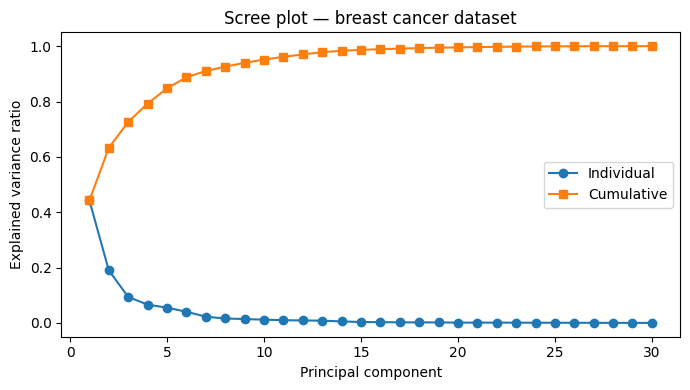

Components retained for 95% variance: 10
Accuracy (original): 0.9707602339181286
Accuracy (PCA 95%): 0.9473684210526315


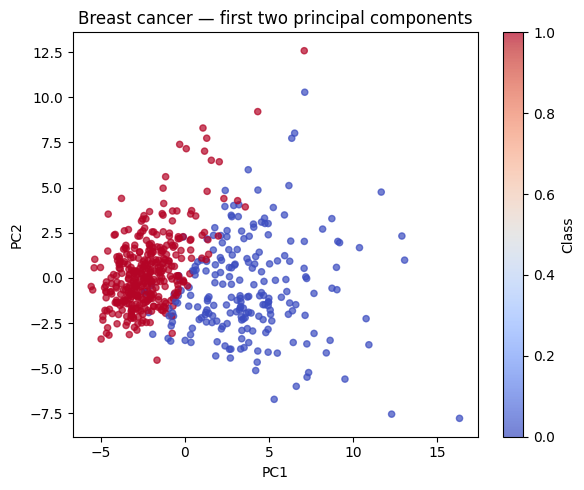

'- **Expectation:**  \n  PCA can reduce dimensionality while preserving most variance, often yielding similar or slightly improved KNN accuracy and faster computation. The scatter of PC1 vs. PC2 typically shows class separation.\n\n---\n'

In [11]:
'''## Question 8: PCA + KNN with variance analysis and visualization

**Answer:**

This workflow computes explained variance (scree plot), retains 95% variance, and compares KNN accuracy before/after PCA. It also visualizes the first two PCs.

'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Standardize before PCA and KNN
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# 2. Scree plot (explained variance ratio)
pca_full = PCA().fit(X_s)
evr = pca_full.explained_variance_ratio_

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(evr)+1), evr, marker='o', label='Individual')
plt.plot(np.arange(1, len(evr)+1), np.cumsum(evr), marker='s', label='Cumulative')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot — breast cancer dataset')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_s)
print("Components retained for 95% variance:", pca.n_components_)

# 4. Train/test split and KNN comparison
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.30, random_state=42, stratify=y)
X_train_p, X_test_p, _, _ = train_test_split(X_pca, y, test_size=0.30, random_state=42, stratify=y)

knn_orig = KNeighborsClassifier(n_neighbors=5)
knn_pca = KNeighborsClassifier(n_neighbors=5)

knn_orig.fit(X_train, y_train)
knn_pca.fit(X_train_p, y_train)

acc_orig = accuracy_score(y_test, knn_orig.predict(X_test))
acc_pca = accuracy_score(y_test, knn_pca.predict(X_test_p))

print("Accuracy (original):", acc_orig)
print("Accuracy (PCA 95%):", acc_pca)

# 5. Visualize first two principal components
# Color by class (0/1)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', s=20, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Breast cancer — first two principal components')
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()

'''- **Expectation:**
  PCA can reduce dimensionality while preserving most variance, often yielding similar or slightly improved KNN accuracy and faster computation. The scatter of PC1 vs. PC2 typically shows class separation.

---
'''

MSE (Euclidean, k=5): 4989.290140034025
MSE (Manhattan, k=5): 5558.437977886144


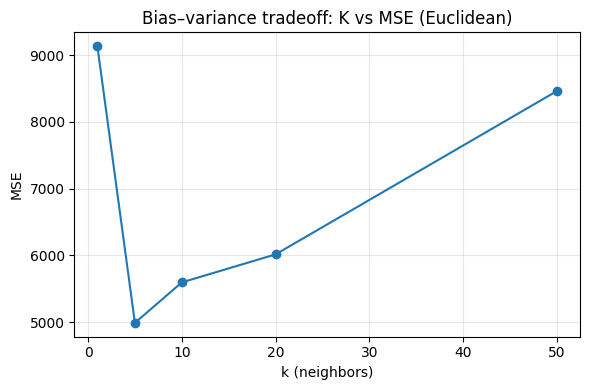

'\n- **Interpretation:**  \n  **Small k (e.g., 1):** Low bias, high variance; may overfit and yield unstable predictions.  \n  **Large k (e.g., 50):** Higher bias, lower variance; smoother predictions but risk underfitting.  \n  The curve typically shows a U-shape, with optimal k balancing bias and variance.\n\n---'

In [12]:
'''## Question 9: KNN regressor — distance metrics and K-value analysis

**Answer:**

This code compares Euclidean vs Manhattan distances and evaluates MSE across different k to observe bias–variance tradeoff.

'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# 1. Synthetic regression data
X, y = make_regression(n_samples=500, n_features=10, noise=15.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Standardize for fair distance comparisons
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 2a. Euclidean (k=5)
knn_eu = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn_eu.fit(X_train_s, y_train)
mse_eu = mean_squared_error(y_test, knn_eu.predict(X_test_s))

# 2b. Manhattan (k=5)
knn_ma = KNeighborsRegressor(n_neighbors=5, metric='manhattan')
knn_ma.fit(X_train_s, y_train)
mse_ma = mean_squared_error(y_test, knn_ma.predict(X_test_s))

print("MSE (Euclidean, k=5):", mse_eu)
print("MSE (Manhattan, k=5):", mse_ma)

# 3. K vs MSE curve
k_values = [1, 5, 10, 20, 50]
mses = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_s, y_train)
    mses.append(mean_squared_error(y_test, knn.predict(X_test_s)))

plt.figure(figsize=(6,4))
plt.plot(k_values, mses, marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('MSE')
plt.title('Bias–variance tradeoff: K vs MSE (Euclidean)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''
- **Interpretation:**
  **Small k (e.g., 1):** Low bias, high variance; may overfit and yield unstable predictions.
  **Large k (e.g., 50):** Higher bias, lower variance; smoother predictions but risk underfitting.
  The curve typically shows a U-shape, with optimal k balancing bias and variance.

---'''

In [7]:

# To install a library, use the `pip install` command
# For example, to install pandas:
!pip install pandas

# You can also install multiple libraries at once:
# !pip install numpy scikit-learn matplotlib

# If you need to install a specific version of a library:
# !pip install beautifulsoup4==4.9.3

# Or install from a GitHub repository:
# !pip install git+https://github.com/username/repository.git


```markdown
**Explanation:**
- The `!` prefix allows you to run shell commands directly in a Colab (or Jupyter) notebook cell.
- `pip install` is the standard command-line tool for installing Python packages.
- Replace `pandas` with the name of the library you want to install.
```

Brute-force:  Accuracy = 0.7489177489177489  Time = 0.0012s
KD-Tree:      Accuracy = 0.7489177489177489  Time = 0.0018s
Ball Tree:    Accuracy = 0.7489177489177489  Time = 0.0019s
Best method: ('brute', 0.7489177489177489, 0.0012440681457519531)


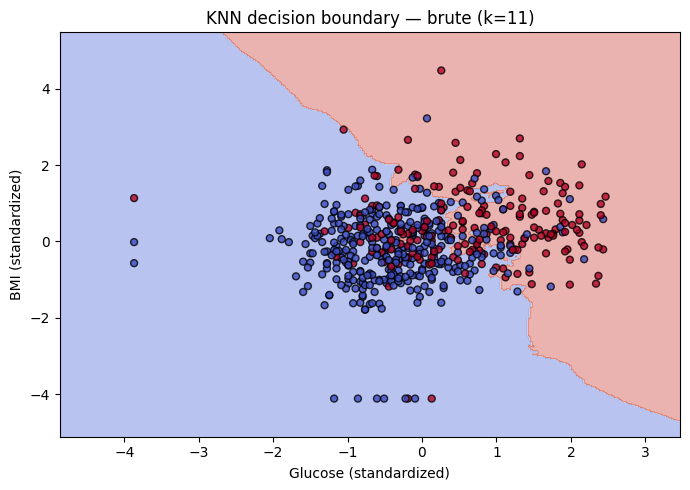

'\n\n- **Notes:**  \n  - **Imputation:** KNNImputer leverages feature similarity to fill missing values, often better than mean imputation.  \n  - **Algorithms:**  \n    - **Brute-force:** Exact distances; slower on large n, stable accuracy.  \n    - **KD-Tree:** Fast on low-dimensional, continuous features (Euclidean-like).  \n    - **Ball Tree:** Better for higher dimensions or non-uniform distributions.  \n  - **Decision boundary:** Using Glucose and BMI provides interpretable visualization; consider feature importance or model-agnostic measures to pick features in practice.\n'

In [16]:
'''## Question 10: KNN with KD-Tree/Ball Tree, imputation, and real-world data

**Answer:**

This pipeline imputes missing values in Pima Indians Diabetes, compares brute-force vs KD-Tree vs Ball Tree KNN, and plots a decision boundary using two important features.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# 1. Load dataset
# If using local CSV: replace the path accordingly
# Common features: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
df = pd.read_csv('/content/Pima Indians Diabetes.csv')  # ensure this file is available
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

# 2. KNN Imputation
imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

# Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

def train_eval_knn(algorithm):
    knn = KNeighborsClassifier(n_neighbors=11, metric='minkowski', p=2, algorithm=algorithm)
    t0 = time.time()
    knn.fit(X_train_s, y_train)
    train_time = time.time() - t0
    acc = accuracy_score(y_test, knn.predict(X_test_s))
    return acc, train_time

# 3. Train KNN with different algorithms
acc_brute, time_brute = train_eval_knn('brute')
acc_kd, time_kd = train_eval_knn('kd_tree')
acc_ball, time_ball = train_eval_knn('ball_tree')

print("Brute-force:  Accuracy =", acc_brute, " Time =", f"{time_brute:.4f}s")
print("KD-Tree:      Accuracy =", acc_kd,    " Time =", f"{time_kd:.4f}s")
print("Ball Tree:    Accuracy =", acc_ball,  " Time =", f"{time_ball:.4f}s")

# 4. Choose best-performing method
methods = [('brute', acc_brute, time_brute), ('kd_tree', acc_kd, time_kd), ('ball_tree', acc_ball, time_ball)]
best_method = sorted(methods, key=lambda t: (t[1], -t[2]), reverse=True)[0]
print("Best method:", best_method)

# 5. Decision boundary using 2 most important features
# For simplicity, select Glucose and BMI (commonly predictive).
cols = df.columns.tolist()
feat_indices = [cols.index('Glucose'), cols.index('BMI')]
X2 = X_imp[:, feat_indices]
y2 = y

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=42, stratify=y2)
scaler2 = StandardScaler()
X2_train_s = scaler2.fit_transform(X2_train)
X2_test_s = scaler2.transform(X2_test)

knn_best_2d = KNeighborsClassifier(n_neighbors=11, metric='minkowski', p=2, algorithm=best_method[0])
knn_best_2d.fit(X2_train_s, y2_train)

# Meshgrid
x_min, x_max = X2_train_s[:,0].min()-1, X2_train_s[:,0].max()+1
y_min, y_max = X2_train_s[:,1].min()-1, X2_train_s[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = knn_best_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)
plt.scatter(X2_train_s[:,0], X2_train_s[:,1], c=y2_train, cmap='coolwarm', edgecolor='k', s=25, alpha=0.8)
plt.xlabel('Glucose (standardized)')
plt.ylabel('BMI (standardized)')
plt.title(f'KNN decision boundary — {best_method[0]} (k=11)')
plt.tight_layout()
plt.show()

'''

- **Notes:**
  - **Imputation:** KNNImputer leverages feature similarity to fill missing values, often better than mean imputation.
  - **Algorithms:**
    - **Brute-force:** Exact distances; slower on large n, stable accuracy.
    - **KD-Tree:** Fast on low-dimensional, continuous features (Euclidean-like).
    - **Ball Tree:** Better for higher dimensions or non-uniform distributions.
  - **Decision boundary:** Using Glucose and BMI provides interpretable visualization; consider feature importance or model-agnostic measures to pick features in practice.
'''